# NovaPay Fraud Detection — Exploratory Data Analysis (EDA)

This notebook explores the cleaned NovaPay transactions dataset and highlights **fraud vs non‑fraud patterns** using descriptive statistics, visualizations, and bucketed risk views.

**What this notebook covers**
- Load the cleaned dataset (`Nova_cleaned_df.csv`)
- Quick sanity checks (shape, types, missing values)
- Univariate and bivariate analysis (fraud distribution, feature distributions)
- Risk signal exploration (device trust, IP risk, velocity, KYC, mismatch)
- Correlations among numeric risk features
- Save an EDA-ready CSV snapshot


## 1) Setup

Import libraries and configure plotting defaults.

In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)

print("✅ Libraries loaded")


✅ Libraries loaded


## 2) Load cleaned dataset

> Expected input: `../data/Nova_cleaned_df.csv`  
If your folder name is different, update the path below.


In [5]:
DATA_PATH = "/content/sample_data/Nova_cleaned_df.csv"  # update if needed

df = pd.read_csv(DATA_PATH)

print("📌 Dataset Shape:", df.shape)
display(df.head())


📌 Dataset Shape: (11137, 26)


,transaction_id,customer_id,timestamp,home_country,source_currency,dest_currency,channel,amount_src,amount_usd,fee,...,ip_risk_score,kyc_tier,account_age_days,device_trust_score,chargeback_history_count,risk_score_internal,txn_velocity_1h,txn_velocity_24h,corridor_risk,is_fraud
0,a3d2ad59-8e0f-4b33-b9cf-48bdca536e2f,22c3f4f2-23a3-4f40-adc0-307dff722216,2023-12-03 01:18:32.573611+00:00,UK,GBP,NGN,WEB,2267.24,2834.05,34.35,...,0.929,LOW,24,0.027,1,0.312,8,11,0.22,1
1,ff87e7e7-7647-4059-8691-1a6d3e5251c2,db2b26f9-e12f-49d9-bf2f-73ae77a0d81f,2023-12-03 13:05:30.573611+00:00,US,USD,NGN,WEB,624.63,624.63,9.78,...,1.000,LOW,14,0.566,0,0.311,6,7,0.00,1
2,5664b84f-2c90-4539-a5d9-6ec3bec881c5,74224638-f8fd-4ca1-91b0-244ffb6f7310,2023-12-05 03:38:56.573611+00:00,CA,CAD,INR,WEB,642.36,475.35,11.43,...,1.000,LOW,65,0.386,1,0.425,7,8,0.12,1
3,771f1ad8-3902-4531-bb3c-6a4fa37ae438,93ca016d-93a2-4b86-b170-8871a9e4561e,2023-12-05 14:58:16.573611+00:00,US,USD,PHP,WEB,938.16,938.16,14.58,...,1.000,LOW,29,0.337,2,0.758,6,7,0.10,1
4,41dffb0b-2515-46ff-814c-724fa0f50c99,6ab3647c-b86e-4018-8fba-4077e0bf986a,2023-12-06 13:59:05.573611+00:00,US,USD,MXN,MOBILE,114.51,114.51,1.97,...,0.254,STANDARD,1095,0.566,0,0.225,1,2,0.00,0


## 3) Dataset overview

We review data types, missing values, and convert `timestamp` to datetime (if needed).

In [6]:
display(df.info())

# Convert timestamp to datetime if it isn't already
if df["timestamp"].dtype == "object":
    df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce", utc=True)

print("\n📌 Missing values per column:")
display(df.isna().sum().sort_values(ascending=False))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11137 entries, 0 to 11136
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   transaction_id             11137 non-null  object 
 1   customer_id                11137 non-null  object 
 2   timestamp                  11137 non-null  object 
 3   home_country               11137 non-null  object 
 4   source_currency            11137 non-null  object 
 5   dest_currency              11137 non-null  object 
 6   channel                    11137 non-null  object 
 7   amount_src                 11137 non-null  float64
 8   amount_usd                 11137 non-null  float64
 9   fee                        11137 non-null  float64
 10  exchange_rate_src_to_dest  11137 non-null  float64
 11  device_id                  11137 non-null  object 
 12  new_device                 11137 non-null  int64  
 13  ip_address                 11137 non-null  obj

None


📌 Missing values per column:


,0
transaction_id,0
customer_id,0
timestamp,0
home_country,0
source_currency,0
dest_currency,0
channel,0
amount_src,0
amount_usd,0
fee,0


## 4) Fraud distribution (target)

We start with a simple look at class balance and fraud rate.

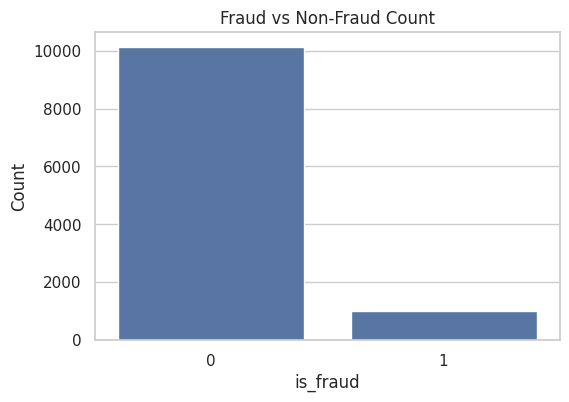

Fraud Rate: 8.92%


In [7]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x="is_fraud")
plt.title("Fraud vs Non‑Fraud Count")
plt.xlabel("is_fraud")
plt.ylabel("Count")
plt.show()

fraud_rate = df["is_fraud"].mean()
print(f"Fraud Rate: {fraud_rate*100:.2f}%")


## 5) Numeric feature distributions

Histograms help spot skew, outliers, and unusual ranges.

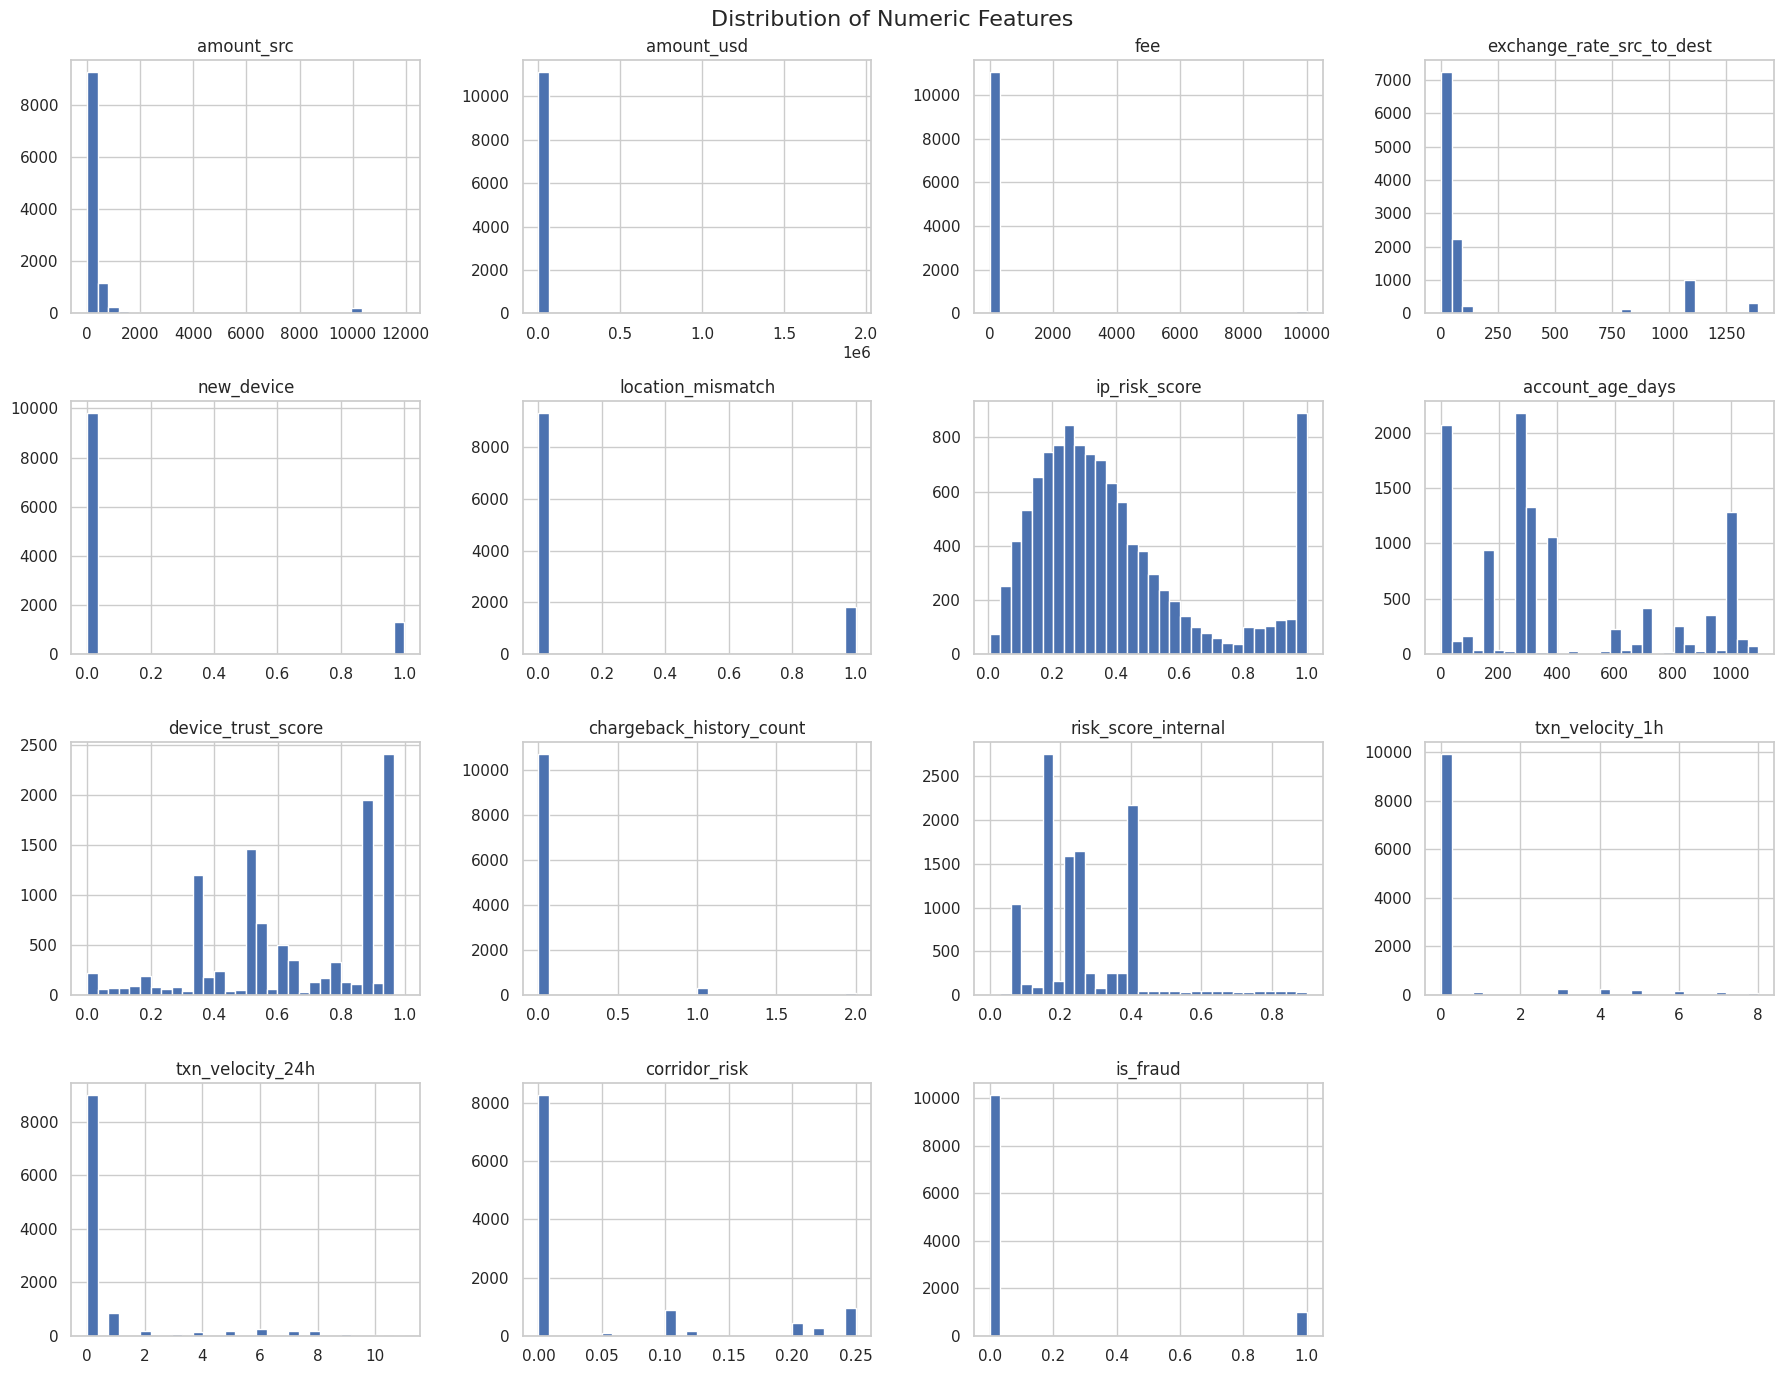

In [8]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

df[numeric_cols].hist(bins=30, figsize=(18, 14))
plt.suptitle("Distribution of Numeric Features", fontsize=16)
plt.tight_layout()
plt.show()


## 6) Key categorical distributions

We focus on **channel** and **KYC tier**, which are often strong fraud signals in payments.

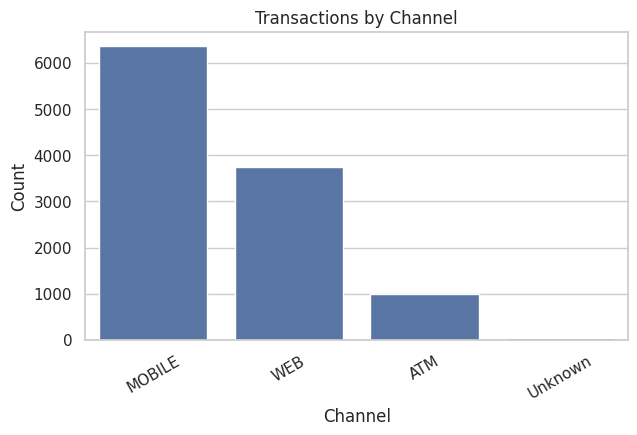

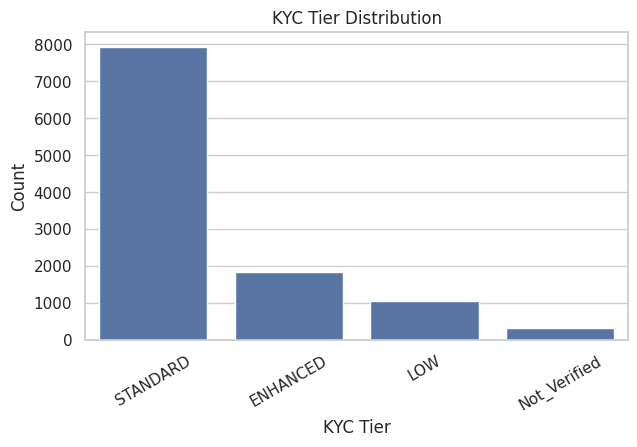

In [9]:
# Channel usage
plt.figure(figsize=(7,4))
sns.countplot(data=df, x="channel", order=df["channel"].value_counts().index)
plt.title("Transactions by Channel")
plt.xlabel("Channel")
plt.ylabel("Count")
plt.xticks(rotation=30)
plt.show()

# KYC tier distribution
plt.figure(figsize=(7,4))
sns.countplot(data=df, x="kyc_tier", order=df["kyc_tier"].value_counts().index)
plt.title("KYC Tier Distribution")
plt.xlabel("KYC Tier")
plt.ylabel("Count")
plt.xticks(rotation=30)
plt.show()


## 7) Location mismatch vs fraud

If the IP country and home country don’t align, fraud risk often increases.

Fraud rate by location_mismatch:


,is_fraud
location_mismatch,
0,0.036052
1,0.361585


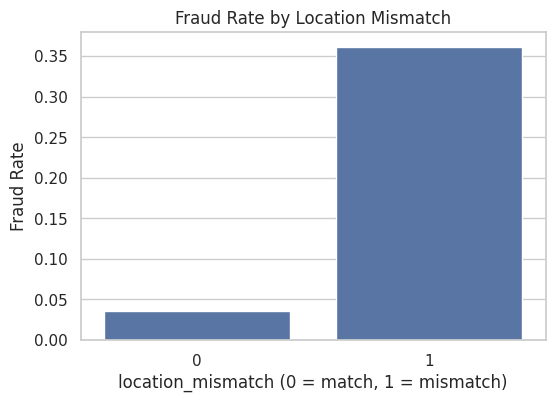

In [10]:
mismatch_fraud_rate = df.groupby("location_mismatch")["is_fraud"].mean()
print("Fraud rate by location_mismatch:")
display(mismatch_fraud_rate)

plt.figure(figsize=(6,4))
sns.barplot(x=mismatch_fraud_rate.index.astype(str), y=mismatch_fraud_rate.values)
plt.title("Fraud Rate by Location Mismatch")
plt.xlabel("location_mismatch (0 = match, 1 = mismatch)")
plt.ylabel("Fraud Rate")
plt.show()


## 8) Bivariate analysis (Fraud vs key numeric features)

We compare distributions between fraud and non‑fraud for the strongest numeric signals.

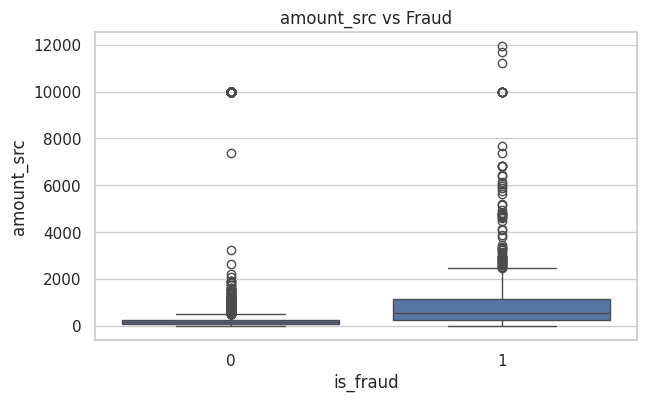

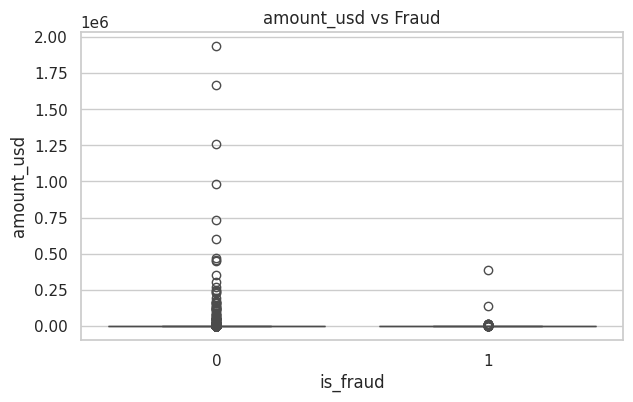

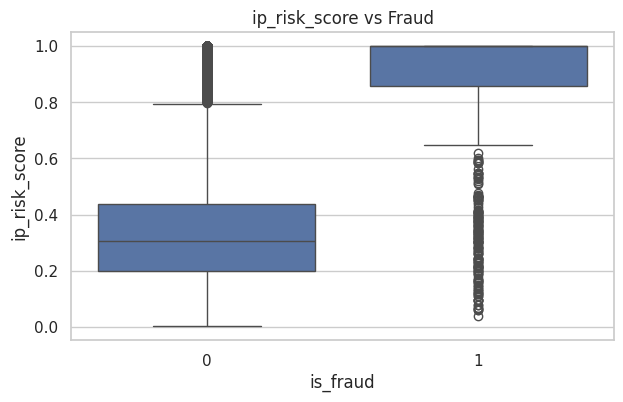

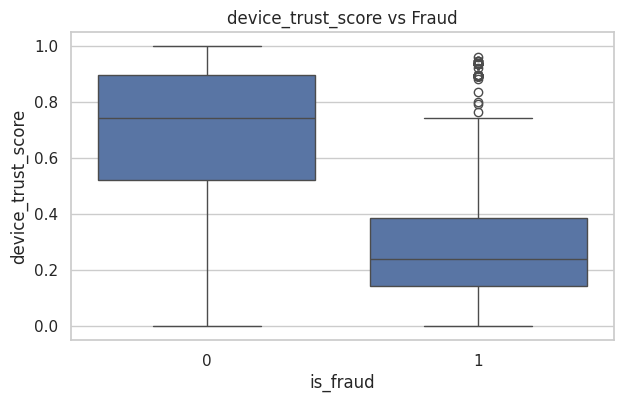

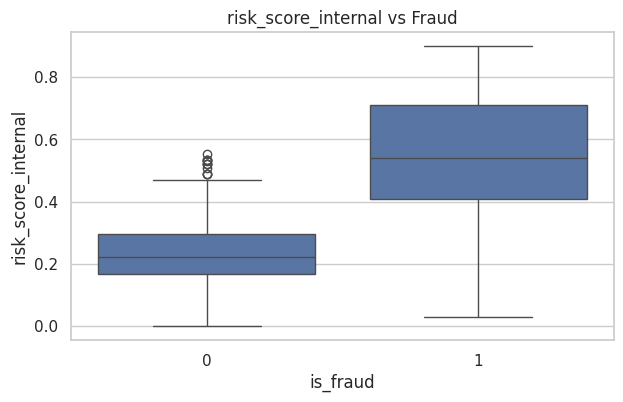

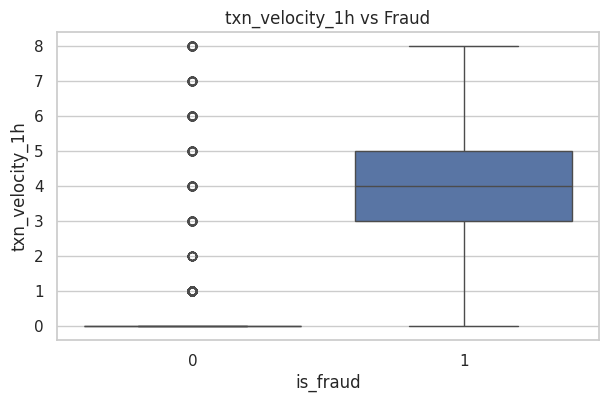

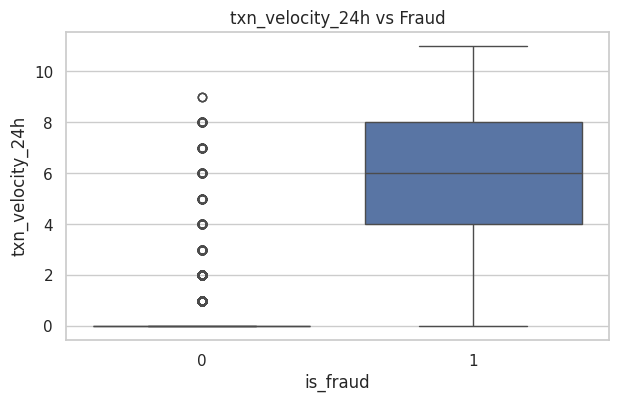

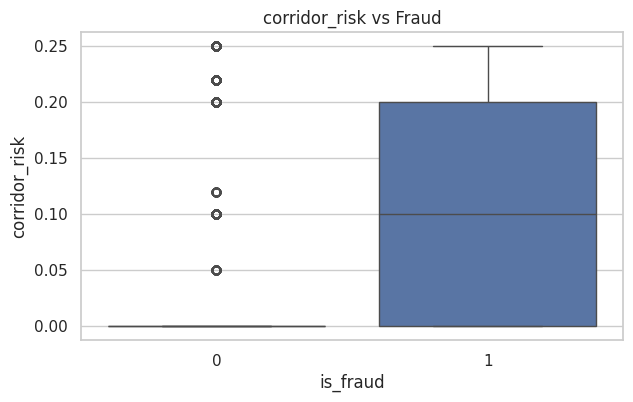

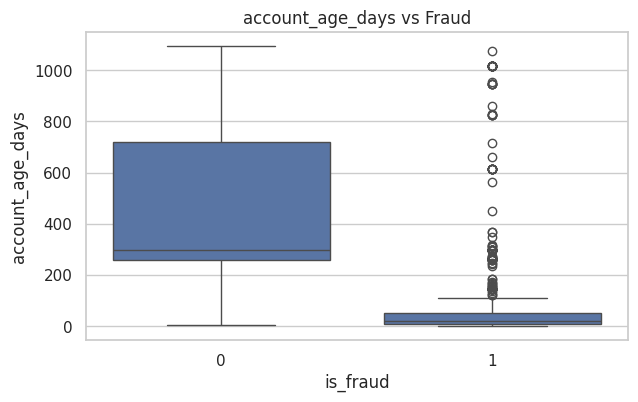

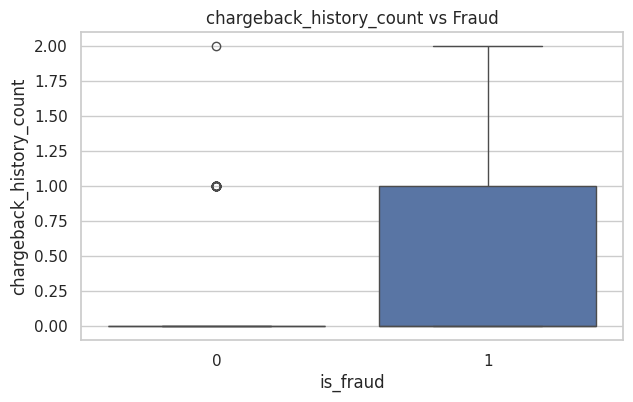

In [11]:
key_numeric = [
    "amount_src",
    "amount_usd",
    "ip_risk_score",
    "device_trust_score",
    "risk_score_internal",
    "txn_velocity_1h",
    "txn_velocity_24h",
    "corridor_risk",
    "account_age_days",
    "chargeback_history_count",
]

for col in key_numeric:
    if col not in df.columns:
        continue
    plt.figure(figsize=(7,4))
    sns.boxplot(data=df, x="is_fraud", y=col)
    plt.title(f"{col} vs Fraud")
    plt.xlabel("is_fraud")
    plt.ylabel(col)
    plt.show()


## 9) Fraud counts by home country and channel

Counts are useful, but remember they are influenced by overall volume.

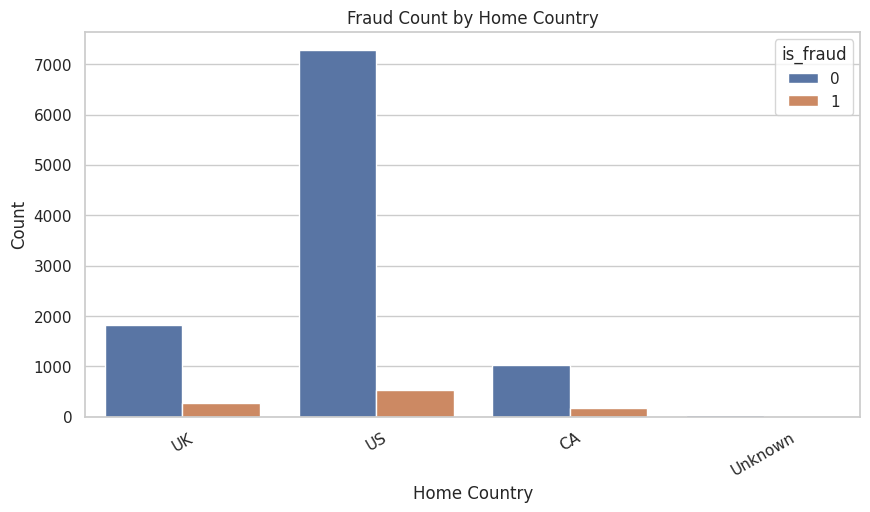

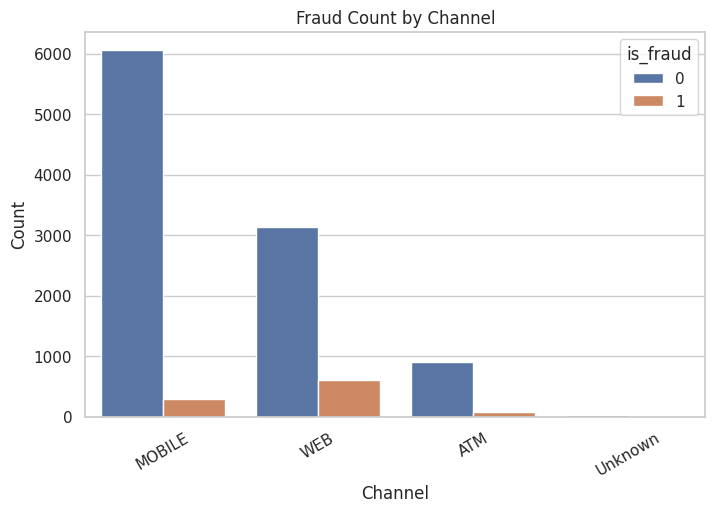

In [12]:
plt.figure(figsize=(10,5))
sns.countplot(data=df, x="home_country", hue="is_fraud")
plt.title("Fraud Count by Home Country")
plt.xlabel("Home Country")
plt.ylabel("Count")
plt.xticks(rotation=30)
plt.show()

plt.figure(figsize=(8,5))
sns.countplot(data=df, x="channel", hue="is_fraud", order=df["channel"].value_counts().index)
plt.title("Fraud Count by Channel")
plt.xlabel("Channel")
plt.ylabel("Count")
plt.xticks(rotation=30)
plt.show()


## 10) Fraud rates by risk segments (bucket analysis)

Bucket views make it easier to communicate how risk changes across ranges.

,is_fraud
device_trust_score,
<0.3,0.671397
0.3–0.5,0.113714
0.5–0.7,0.020927
0.7–0.9,0.032920
0.9–1.0,0.008268


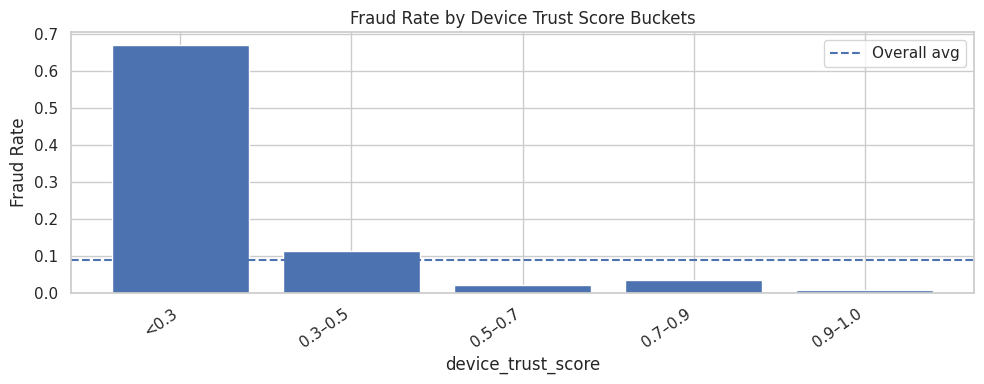

,is_fraud
ip_risk_score,
<0.3,0.015188
0.3–0.5,0.022407
0.5–0.7,0.029963
0.7–0.9,0.227273
0.9–1.0,0.618007


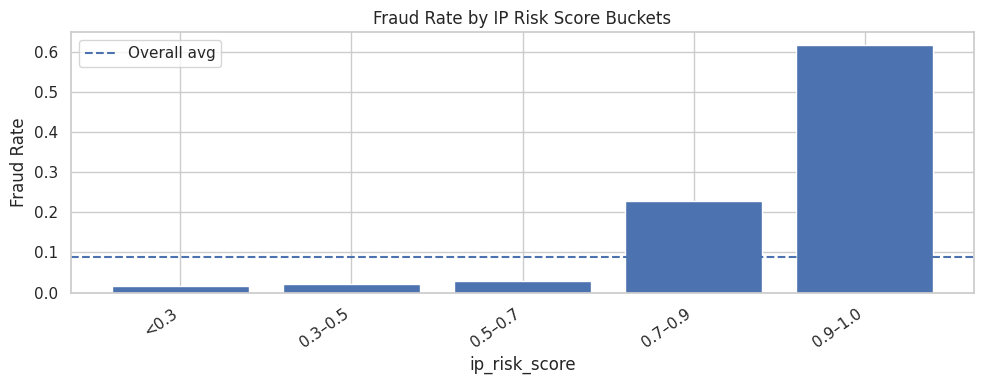

,is_fraud
amount_usd,
<$100,0.018868
$100–500,0.061159
$500–1k,0.291768
$1–2k,0.647273
$2–5k,0.777778
>$5k,0.114391


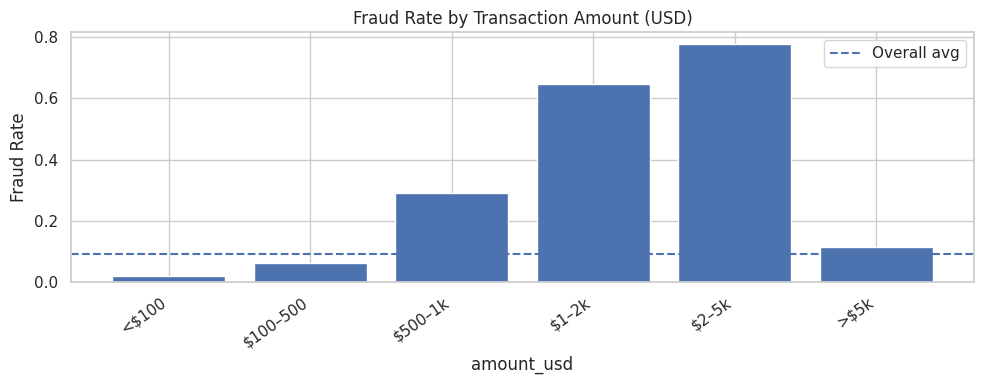

In [13]:
overall = df["is_fraud"].mean()

def plot_bucket_rate(series, bins, labels, title, xlabel):
    bucket = pd.cut(series, bins=bins, labels=labels, include_lowest=True)
    rates = df.groupby(bucket, observed=True)["is_fraud"].mean()
    display(rates)

    plt.figure(figsize=(10,4))
    plt.bar(range(len(rates)), rates.values)
    plt.xticks(range(len(rates)), rates.index.astype(str), rotation=35, ha="right")
    plt.xlabel(xlabel)
    plt.ylabel("Fraud Rate")
    plt.title(title)
    plt.axhline(y=overall, linestyle="--", label="Overall avg")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Device trust score buckets
if "device_trust_score" in df.columns:
    plot_bucket_rate(
        df["device_trust_score"],
        bins=[0, 0.3, 0.5, 0.7, 0.9, 1.0],
        labels=["<0.3", "0.3–0.5", "0.5–0.7", "0.7–0.9", "0.9–1.0"],
        title="Fraud Rate by Device Trust Score Buckets",
        xlabel="device_trust_score"
    )

# IP risk buckets
if "ip_risk_score" in df.columns:
    plot_bucket_rate(
        df["ip_risk_score"],
        bins=[0, 0.3, 0.5, 0.7, 0.9, 1.0],
        labels=["<0.3", "0.3–0.5", "0.5–0.7", "0.7–0.9", "0.9–1.0"],
        title="Fraud Rate by IP Risk Score Buckets",
        xlabel="ip_risk_score"
    )

# Amount buckets (USD)
if "amount_usd" in df.columns:
    plot_bucket_rate(
        df["amount_usd"],
        bins=[0, 100, 500, 1000, 2000, 5000, 20000],
        labels=["<$100", "$100–500", "$500–1k", "$1–2k", "$2–5k", ">$5k"],
        title="Fraud Rate by Transaction Amount (USD)",
        xlabel="amount_usd"
    )


## 11) Fraud rates by velocity (1h and 24h)

Velocity often captures bursty behavior typical of fraud attempts.

,is_fraud
txn_velocity_1h,
0,0.018037
1,0.000000
2,0.000000
3,0.835878
4,0.838843
5,0.809524
6,0.704142
7,0.690265
8,0.477273


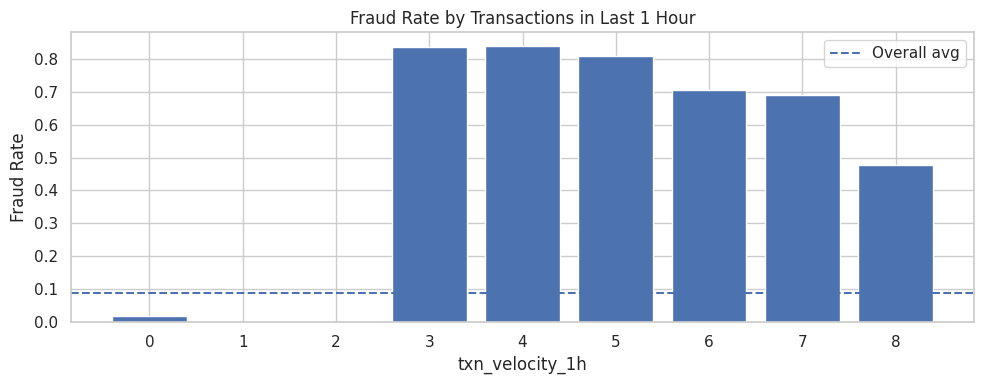

,is_fraud
txn_velocity_24h,
0,0.018299
1,0.016607
2,0.000000
3,0.042254
4,0.572464
5,0.790123
6,0.796813
7,0.806283
8,0.730539


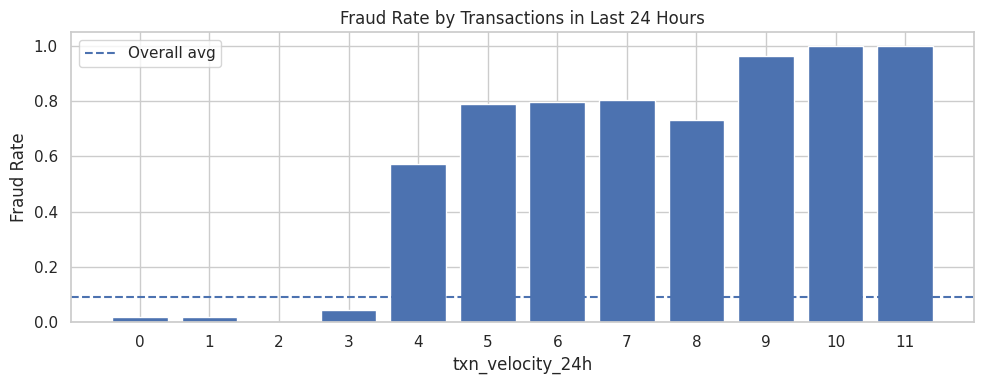

In [14]:
def plot_rate_by_discrete(col, title, xlabel):
    rates = df.groupby(col, observed=True)["is_fraud"].mean().sort_index()
    display(rates)

    plt.figure(figsize=(10,4))
    plt.bar(rates.index.astype(str), rates.values)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Fraud Rate")
    plt.axhline(y=df["is_fraud"].mean(), linestyle="--", label="Overall avg")
    plt.legend()
    plt.tight_layout()
    plt.show()

if "txn_velocity_1h" in df.columns:
    plot_rate_by_discrete("txn_velocity_1h", "Fraud Rate by Transactions in Last 1 Hour", "txn_velocity_1h")

if "txn_velocity_24h" in df.columns:
    plot_rate_by_discrete("txn_velocity_24h", "Fraud Rate by Transactions in Last 24 Hours", "txn_velocity_24h")


## 12) Account age and chargeback history

These are classic fraud signals: **new accounts** and **prior chargebacks** can drive risk.

,is_fraud
account_age_days,
<30d,0.355789
30–90d,0.437647
90–180d,0.025176
180–365d,0.016944
1–2yr,0.007784
>2yr,0.013089


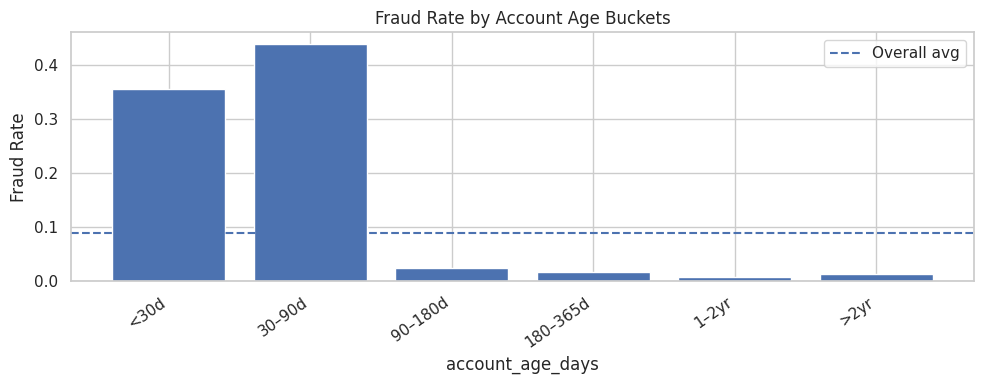

,is_fraud
chargeback_history_count,
0,0.053852
1,0.930303
2,0.990991


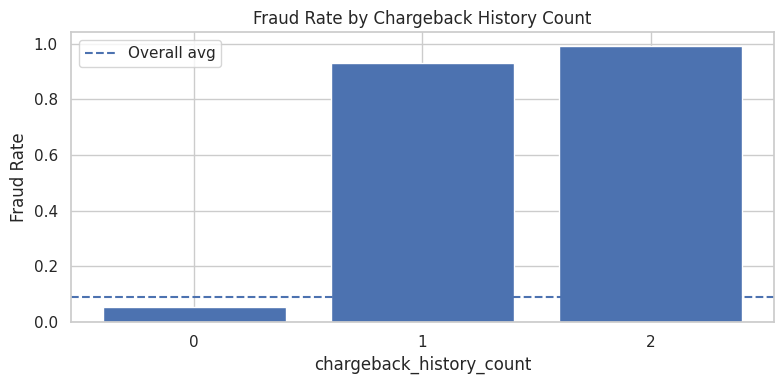

In [15]:
# Account age buckets
if "account_age_days" in df.columns:
    age_bucket = pd.cut(
        df["account_age_days"],
        bins=[0, 30, 90, 180, 365, 730, np.inf],
        labels=["<30d", "30–90d", "90–180d", "180–365d", "1–2yr", ">2yr"],
        include_lowest=True
    )
    age_rates = df.groupby(age_bucket, observed=True)["is_fraud"].mean()
    display(age_rates)

    plt.figure(figsize=(10,4))
    plt.bar(range(len(age_rates)), age_rates.values)
    plt.xticks(range(len(age_rates)), age_rates.index.astype(str), rotation=35, ha="right")
    plt.title("Fraud Rate by Account Age Buckets")
    plt.xlabel("account_age_days")
    plt.ylabel("Fraud Rate")
    plt.axhline(y=df["is_fraud"].mean(), linestyle="--", label="Overall avg")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Chargeback history
if "chargeback_history_count" in df.columns:
    cb_rates = df.groupby("chargeback_history_count", observed=True)["is_fraud"].mean().sort_index()
    display(cb_rates)

    plt.figure(figsize=(8,4))
    plt.bar(cb_rates.index.astype(str), cb_rates.values)
    plt.title("Fraud Rate by Chargeback History Count")
    plt.xlabel("chargeback_history_count")
    plt.ylabel("Fraud Rate")
    plt.axhline(y=df["is_fraud"].mean(), linestyle="--", label="Overall avg")
    plt.legend()
    plt.tight_layout()
    plt.show()


## 13) Fraud rate by fee buckets

Fees can correlate with amount and channel; bucketed fee rates are useful for reporting.

,is_fraud
fee,
<$1,0.006711
$1–2,0.017705
$2–3,0.026625
$3–4,0.031831
$4–5,0.058915
$5–10,0.128878
>$10,0.428959


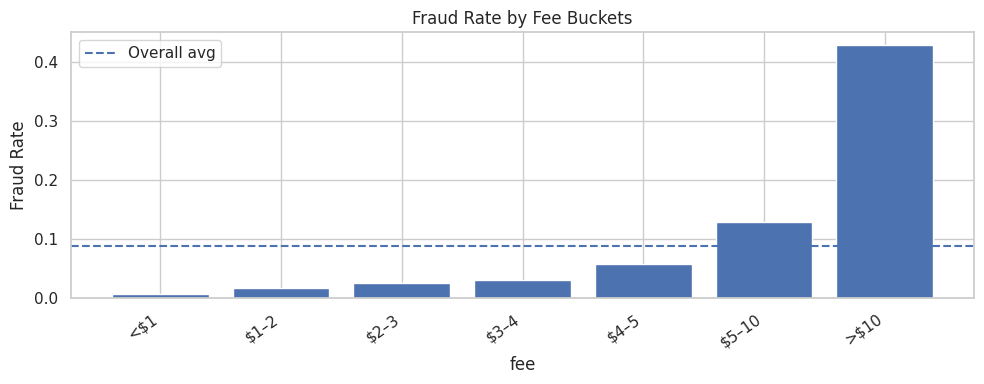

In [16]:
if "fee" in df.columns:
    fee_bucket = pd.cut(
        df["fee"],
        bins=[0, 1, 2, 3, 4, 5, 10, np.inf],
        labels=["<$1", "$1–2", "$2–3", "$3–4", "$4–5", "$5–10", ">$10"],
        include_lowest=True
    )
    fee_rates = df.groupby(fee_bucket, observed=True)["is_fraud"].mean()
    display(fee_rates)

    plt.figure(figsize=(10,4))
    plt.bar(range(len(fee_rates)), fee_rates.values)
    plt.xticks(range(len(fee_rates)), fee_rates.index.astype(str), rotation=35, ha="right")
    plt.title("Fraud Rate by Fee Buckets")
    plt.xlabel("fee")
    plt.ylabel("Fraud Rate")
    plt.axhline(y=df["is_fraud"].mean(), linestyle="--", label="Overall avg")
    plt.legend()
    plt.tight_layout()
    plt.show()


## 14) Correlation heatmap (numeric features)

Correlation won’t prove causation, but it gives a quick view of linear relationships among numeric risk signals.

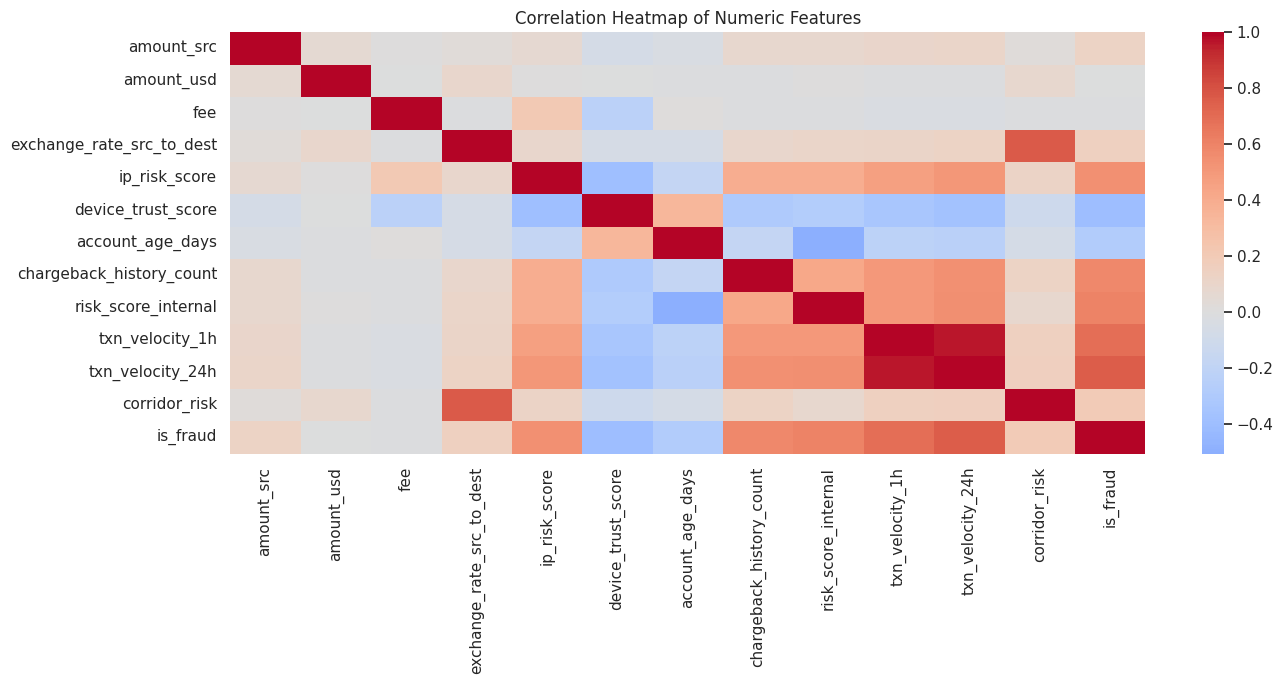

In [17]:
# Select a focused subset to keep the heatmap readable
corr_cols = [
    "amount_src", "amount_usd", "fee", "exchange_rate_src_to_dest",
    "ip_risk_score", "device_trust_score", "account_age_days",
    "chargeback_history_count", "risk_score_internal",
    "txn_velocity_1h", "txn_velocity_24h", "corridor_risk",
    "is_fraud"
]
corr_cols = [c for c in corr_cols if c in df.columns]

plt.figure(figsize=(14,7))
sns.heatmap(df[corr_cols].corr(), cmap="coolwarm", center=0, annot=False)
plt.title("Correlation Heatmap of Numeric Features")
plt.tight_layout()
plt.show()


## 15) Save EDA snapshot

This saves a copy of the dataset (after any EDA-time conversions such as timestamp parsing).  
Update the output path to match your project structure.

In [19]:
import os

OUTPUT_PATH = "/content/data/Nova_CleanedEDA_df.csv"  # update if needed

# Create the directory if it does not exist
output_dir = os.path.dirname(OUTPUT_PATH)
os.makedirs(output_dir, exist_ok=True)

df_eda = df.copy()
df_eda.to_csv(OUTPUT_PATH, index=False)

print(f"✅ Saved EDA dataset to: {OUTPUT_PATH}")

✅ Saved EDA dataset to: /content/data/Nova_CleanedEDA_df.csv
